In [1]:
import numpy as np
import os
import scipy.io as sio
import h5py
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

In [2]:
mask_path = "C:\\Users\\15714\\Desktop\\OA Research\\24 Micron Data\\MasksEpi"
mask_files = [os.path.join(mask_path,i) for i in os.listdir(mask_path)]
mask_files_npy = []
for file in os.listdir(mask_path):
    if file.endswith(".npy"):
        mask_files_npy.append(os.path.join(mask_path, file))

stacks_path = "C:\\Users\\15714\\Desktop\\OA Research\\24 Micron Data\\Stacks"
stacks_files = [os.path.join(stacks_path,i) for i in os.listdir(stacks_path)]
stack_files_npy = []

for file in os.listdir(stacks_path):
    if file.endswith(".npy"):
        stack_files_npy.append(os.path.join(stacks_path, file))

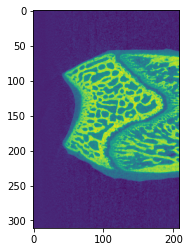

In [4]:
plt.imshow(np.load(stack_files_npy[0])[100,:,:])

In [625]:

with open('bone_mask_array.npy', 'rb') as f:
    bone_masks_array = np.load(f)
with open('stacks_first.npy', 'rb') as f:
    stacks = np.load(f)


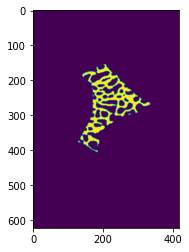

In [629]:
plt.imshow(bone_masks_array[200,:,:])

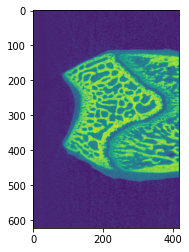

In [630]:
plt.imshow(stacks[200,:,:])

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=1, dim=(346,311,209), n_channels=1,
                 shuffle=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    def loadmat(path,key):
        f = sio.loadmat(path)
        data = f[str(key)]
        data = np.array(data) #mat to np array
    def __getitem__(self, index):
        print("getting item")
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        #isa_path = "S:\\Projects\\Lucas\\ISA\\ISA archive\\Data\\12-micron resolution"
        #tw_mic_path_stacks = os.path.join(isa_path,"Stacks")
        #tw_mic_path_masks = os.path.join(isa_path,"Masks","Epi")

        #stacks_files = [os.path.join(tw_mic_path_stacks,i) for i in os.listdir(tw_mic_path_stacks)]#temp zeroes here
        #masks_files = [os.path.join(tw_mic_path_masks,i) for i in os.listdir(tw_mic_path_masks)]#so it doesn't take forever

        mask_path = "C:\\Users\\15714\\Desktop\\OA Research\\24 Micron Data\\MasksEpi"
        mask_files = [os.path.join(mask_path,i) for i in os.listdir(mask_path)]
        mask_files_npy = []
        for file in os.listdir(mask_path):
            if file.endswith(".npy"):
                mask_files_npy.append(os.path.join(mask_path, file))

        stacks_path = "C:\\Users\\15714\\Desktop\\OA Research\\24 Micron Data\\Stacks"
        stacks_files = [os.path.join(stacks_path,i) for i in os.listdir(stacks_path)]
        stack_files_npy = []

        for file in os.listdir(stacks_path):
            if file.endswith(".npy"):
                stack_files_npy.append(os.path.join(mask_path, file))


        # Generate data
        volumes, masks = self.__data_generation(stack_files_npy,mask_files_npy,index)#use index?

        return volumes,masks

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, stack_files,mask_files,index):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        volumes = np.empty((self.batch_size, *self.dim, self.n_channels))#x=volume y=masks
        masks = np.empty((self.batch_size), dtype=int)

        # Generate data
        for volume,mask in zip(stack_files_npy,mask_files_npy):
            # Store sample
            
            volumes = np.load(volume)
            masks = np.load(mask)

        return volumes,masks

In [ ]:
params = {'dim': (346,311),#bone_masks_array.shape[:,:,0]
          'batch_size': 1,
          'n_channels': np.load(stack_files_npy[0]).shape[2],
          'shuffle': False}

# Datasets
partition = stack_files_npy
labels = mask_files_npy

# Generators
training_generator = DataGenerator(partition, labels, **params)

In [ ]:
#plt.imshow(training_generator.__getitem__(7)[0][:,:,100])
plt.imshow(np.load(stack_files_npy[7])[:,:,100])

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Dense(np.load(stack_files_npy[0]).shape[0]*np.load(stack_files_npy[0]).shape[1]*np.load(stack_files_npy[0]).shape[2], activation='relu'))
model.compile()

# Train model on dataset
#model.fit(training_generator, use_multiprocessing=True)
model.fit(x=np.load(stack_files_npy[0]),y=np.load(stack_files_npy[0]))


<h1>Per Slice Model<h1>


In [665]:
stack_slices = np.load(stack_files_npy[0])[100:150]
mask_slices = np.load(mask_files_npy[0])[100:150]

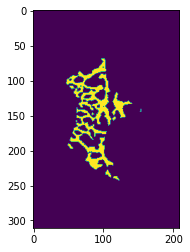

In [660]:
plt.imshow(mask_slices[30,:,:])

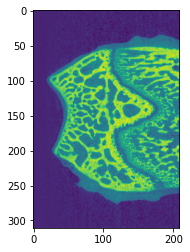

In [661]:
plt.imshow(stack_slices[30,:,:])

In [ ]:
load_real_samples().shape


<h1>Unet from zhixuhao<h1>


In [442]:
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.cast((1 - jac),'float32') * smooth

In [400]:
import keras.backend as K
import tensorflow as tf
import numpy as np
from .wrappers import malis_weights,mknhood3d,seg_to_affgraph

def pairs_to_loss_keras(pos_pairs, neg_pairs, pred, margin=0.3, pos_loss_weight=0.5):
    """
    Computes MALIS loss weights from given positive and negtive weights.
    
    Roughly speaking the malis weights quantify the impact of an edge in
    the predicted affinity graph on the resulting segmentation.
    
    Input:
        pos_pairs: (batch_size, H, W, C)
           Contains the positive pairs 
        neg_pairs: (batch_size, H, W, C)
           Contains the negative pairs 
        pred:  (batch_size, H, W, C)
            affinity predictions from network
    Returns:
        malis_loss: scale
            final malis loss
        
    """
    pos_t = tf.cast(pos_pairs,dtype=tf.float32)
    pos_t = tf.math.divide_no_nan(pos_t,tf.reduce_sum(pos_t))

    neg_t = tf.cast(neg_pairs,dtype=tf.float32)
    neg_t = tf.math.divide_no_nan(neg_t,tf.reduce_sum(neg_t))
    
    neg_loss_weight = 1 - pos_loss_weight
    zeros_helpervar = tf.zeros(shape=tf.shape(pred))

    pos_loss = tf.where(1 - pred - margin > 0,
                        (1 - pred - margin)**2,
                        zeros_helpervar)
    pos_loss = pos_loss * pos_t
    pos_loss = tf.reduce_sum(pos_loss) * pos_loss_weight

    neg_loss = tf.where(pred - margin > 0,
                        (pred - margin)**2,
                        zeros_helpervar)
    neg_loss = neg_loss * neg_t
    neg_loss = tf.reduce_sum(neg_loss) * neg_loss_weight
    malis_loss = (pos_loss + neg_loss) * 2  # because of the pos_loss_weight and neg_loss_weight

    return malis_loss


def malis_loss2d(y_true,y_pred): 
    '''
    Computes 2d MALIS loss given predicted affinity graphs and segmentation groundtruth
    
    Roughly speaking malis weights (pos_pairs and neg_pairs) quantify the 
    impact of an edge in the predicted affinity graph on the resulting segmentation.
    
    Input:
       y_true: Tensor (batch_size, H, W, C = 1)
          segmentation groundtruth
       y_pred: Tensor (batch_size, H, W, C = 3)
           affinity predictions from network
    Returns:
       loss: Tensor(scale)
              malis loss 
      
    Outline:
    - Computes for all pixel-pairs the MaxiMin-Affinity
    - Separately for pixel-pairs that should/should not be connected
    - Every time an affinity prediction is a MaxiMin-Affinity its weight is
      incremented by one in the output matrix (in different slices depending
      on whether that that pair should/should not be connected)
    '''
    
    #########  make sure seg_true and y_pred has the correct shape -> (H,W,C'), (2,H,W,batch) for each     
    x = K.int_shape(y_pred)[1]  # H
    y = K.int_shape(y_pred)[2]  # W

    seg_true = K.reshape(y_true,(x,y,-1))              # (H,W,D)
    y_pred = K.permute_dimensions(y_pred,(3,1,2,0))   # (C=3,H,W,D)

    #########
    nhood = mknhood3d(1)[:-1]
    nhood = tf.cast(nhood,tf.int32)
    
    gtaff = tf.numpy_function(func = seg_to_affgraph,inp=[seg_true, nhood],
                                             Tout=tf.int16) # get groundtruth affinity
    
    weights_pos,weights_neg = tf.py_function(malis_weights,
                         [y_pred, gtaff, seg_true, nhood],
                         [tf.int32,tf.int32])

    loss = pairs_to_loss_keras(weights_pos, weights_neg, y_pred)
    
    return loss


ImportError: attempted relative import with no known parent package

In [3]:
from keras import backend as K

ce_w = .5#0.5
ce_d_w = 0.5
e = K.epsilon()
smooth = 1
'''
ce_w values smaller than 0.5 penalize false positives more while values larger than 0.5 penalize false negatives more
ce_d_w is level of contribution of the cross-entropy loss in the total loss.
'''

def Combo_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    d = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    y_pred_f = K.clip(y_pred_f, e, 1.0 - e)
    out = - (ce_w * y_true_f * K.log(y_pred_f)) + ((1 - ce_w) * (1.0 - y_true_f) * K.log(1.0 - y_pred_f))
    weighted_ce = K.mean(out, axis=-1)
    combo = (ce_d_w * weighted_ce) - ((1 - ce_d_w) * d)
    return combo
def Active_Contour_Loss(y_true, y_pred): 

    """
    lenth term
    """

    x = y_pred[:,:,1:,:] - y_pred[:,:,:-1,:] # horizontal and vertical directions 
    y = y_pred[:,:,:,1:] - y_pred[:,:,:,:-1]

    delta_x = x[:,:,1:,:-2]**2
    delta_y = y[:,:,:-2,1:]**2
    delta_u = K.abs(delta_x + delta_y) 

    lenth = K.mean(K.sqrt(delta_u + 0.00000001)) # equ.(11) in the paper

    """
    region term
    """

    C_1 = np.ones((256, 256))
    C_2 = np.zeros((256, 256))

    region_in = K.abs(K.mean( y_pred[:,0,:,:] * ((y_true[:,0,:,:] - C_1)**2) ) ) # equ.(12) in the paper
    region_out = K.abs(K.mean( (1-y_pred[:,0,:,:]) * ((y_true[:,0,:,:] - C_2)**2) )) # equ.(12) in the paper

    lambdaP = 1 # lambda parameter could be various.
    mu = 1 # mu parameter could be various.

    return lenth + lambdaP * (mu * region_in + region_out) 

from keras.losses import binary_crossentropy
import keras.backend as K
import tensorflow as tf 

epsilon = 1e-5
smooth = 1

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall

def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth) 
    return tp 

def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos 
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn 

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [580]:






import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(pretrained_weights = None,input_size = (128,128,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    print("up9 shape",up9.shape)
    merge9=up9
    #merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-5), loss = focal_tversky, metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model


In [4]:
stack_slices = np.expand_dims(stack_slices, axis=-1)
mask_slices = np.expand_dims(mask_slices,axis=-1)

NameError: name 'stack_slices' is not defined

In [6]:
def squarify(M,val,change_dim=0):
    (a,b)=M.shape
    if a>b:
        padding=((0,0),(0,a-b))
    else:
        padding=((0,b-a),(0,0))
    return np.pad(M,padding,mode='constant',constant_values=val)

In [664]:
stack_slices.shape

(50, 311, 209, 1)

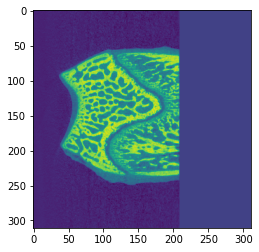

In [666]:
plt.imshow(squarify(stack_slices[5,:,:],0))

In [76]:
stack_list = []
mask_list = []
stack_like = np.zeros((stack_slices.shape[0],stack_slices.shape[0]))
mask_like = np.zeros((mask_slices.shape[0],mask_slices.shape[0]))

NameError: name 'stack_slices' is not defined

In [668]:
for i in range(stack_like.shape[0]):
    stack_list.append(squarify(stack_slices[i],0,change_dim=1)[:256,:256])
    mask_list.append(squarify(mask_slices[i],0,change_dim=1)[:256,:256])

In [676]:
u_stack.shape

(50, 256, 256, 1)

In [75]:
u_stack = np.asarray(np.expand_dims(stack_list, axis=-1))
u_mask = np.expand_dims(mask_list, axis=-1)

NameError: name 'stack_list' is not defined

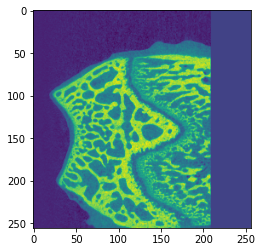

In [677]:
plt.imshow(u_stack[30,:,:,0])

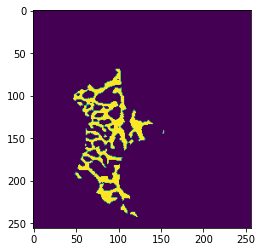

In [678]:
plt.imshow(u_mask[30,:,:,0])

In [ ]:
#from model import *
#from data import *

#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

'''
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
#myGene = trainGenerator(2,'data/membrane/train','image','label',data_gen_args,save_to_dir = None)
'''
model = unet(input_size = (256,256,1))
#model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)

#model.fit_generator(myGene,steps_per_epoch=1,epochs=1)

model.fit((u_stack/1000).astype('float32'),u_mask.astype('float32'),epochs=300)

#testGene = testGenerator("data/membrane/test")
#results = model.predict_generator(stack_slices,mask_slices,epochs=1)
#saveResult("data/membrane/test",results)

up9 shape (None, 256, 256, 64)
Epoch 1/300
2/2 [==============================] - 93s 34s/step - loss: 0.9603 - accuracy: 0.8273
Epoch 2/300
2/2 [==============================] - 98s 35s/step - loss: 0.8950 - accuracy: 0.1868
Epoch 3/300
2/2 [==============================] - 104s 36s/step - loss: 0.8949 - accuracy: 0.1439
Epoch 4/300
2/2 [==============================] - 98s 35s/step - loss: 0.8941 - accuracy: 0.1507
Epoch 5/300
2/2 [==============================] - 96s 34s/step - loss: 0.8938 - accuracy: 0.1832
Epoch 6/300
2/2 [==============================] - 97s 35s/step - loss: 0.8901 - accuracy: 0.2451
Epoch 7/300
2/2 [==============================] - 97s 35s/step - loss: 0.8815 - accuracy: 0.3581
Epoch 8/300
2/2 [==============================] - 97s 35s/step - loss: 0.8654 - accuracy: 0.5961
Epoch 9/300
2/2 [==============================] - 96s 35s/step - loss: 0.8540 - accuracy: 0.6495
Epoch 10/300
2/2 [==============================] - 97s 35s/step - loss: 0.8432 - accu

In [ ]:
predict = model.predict(u_stack)

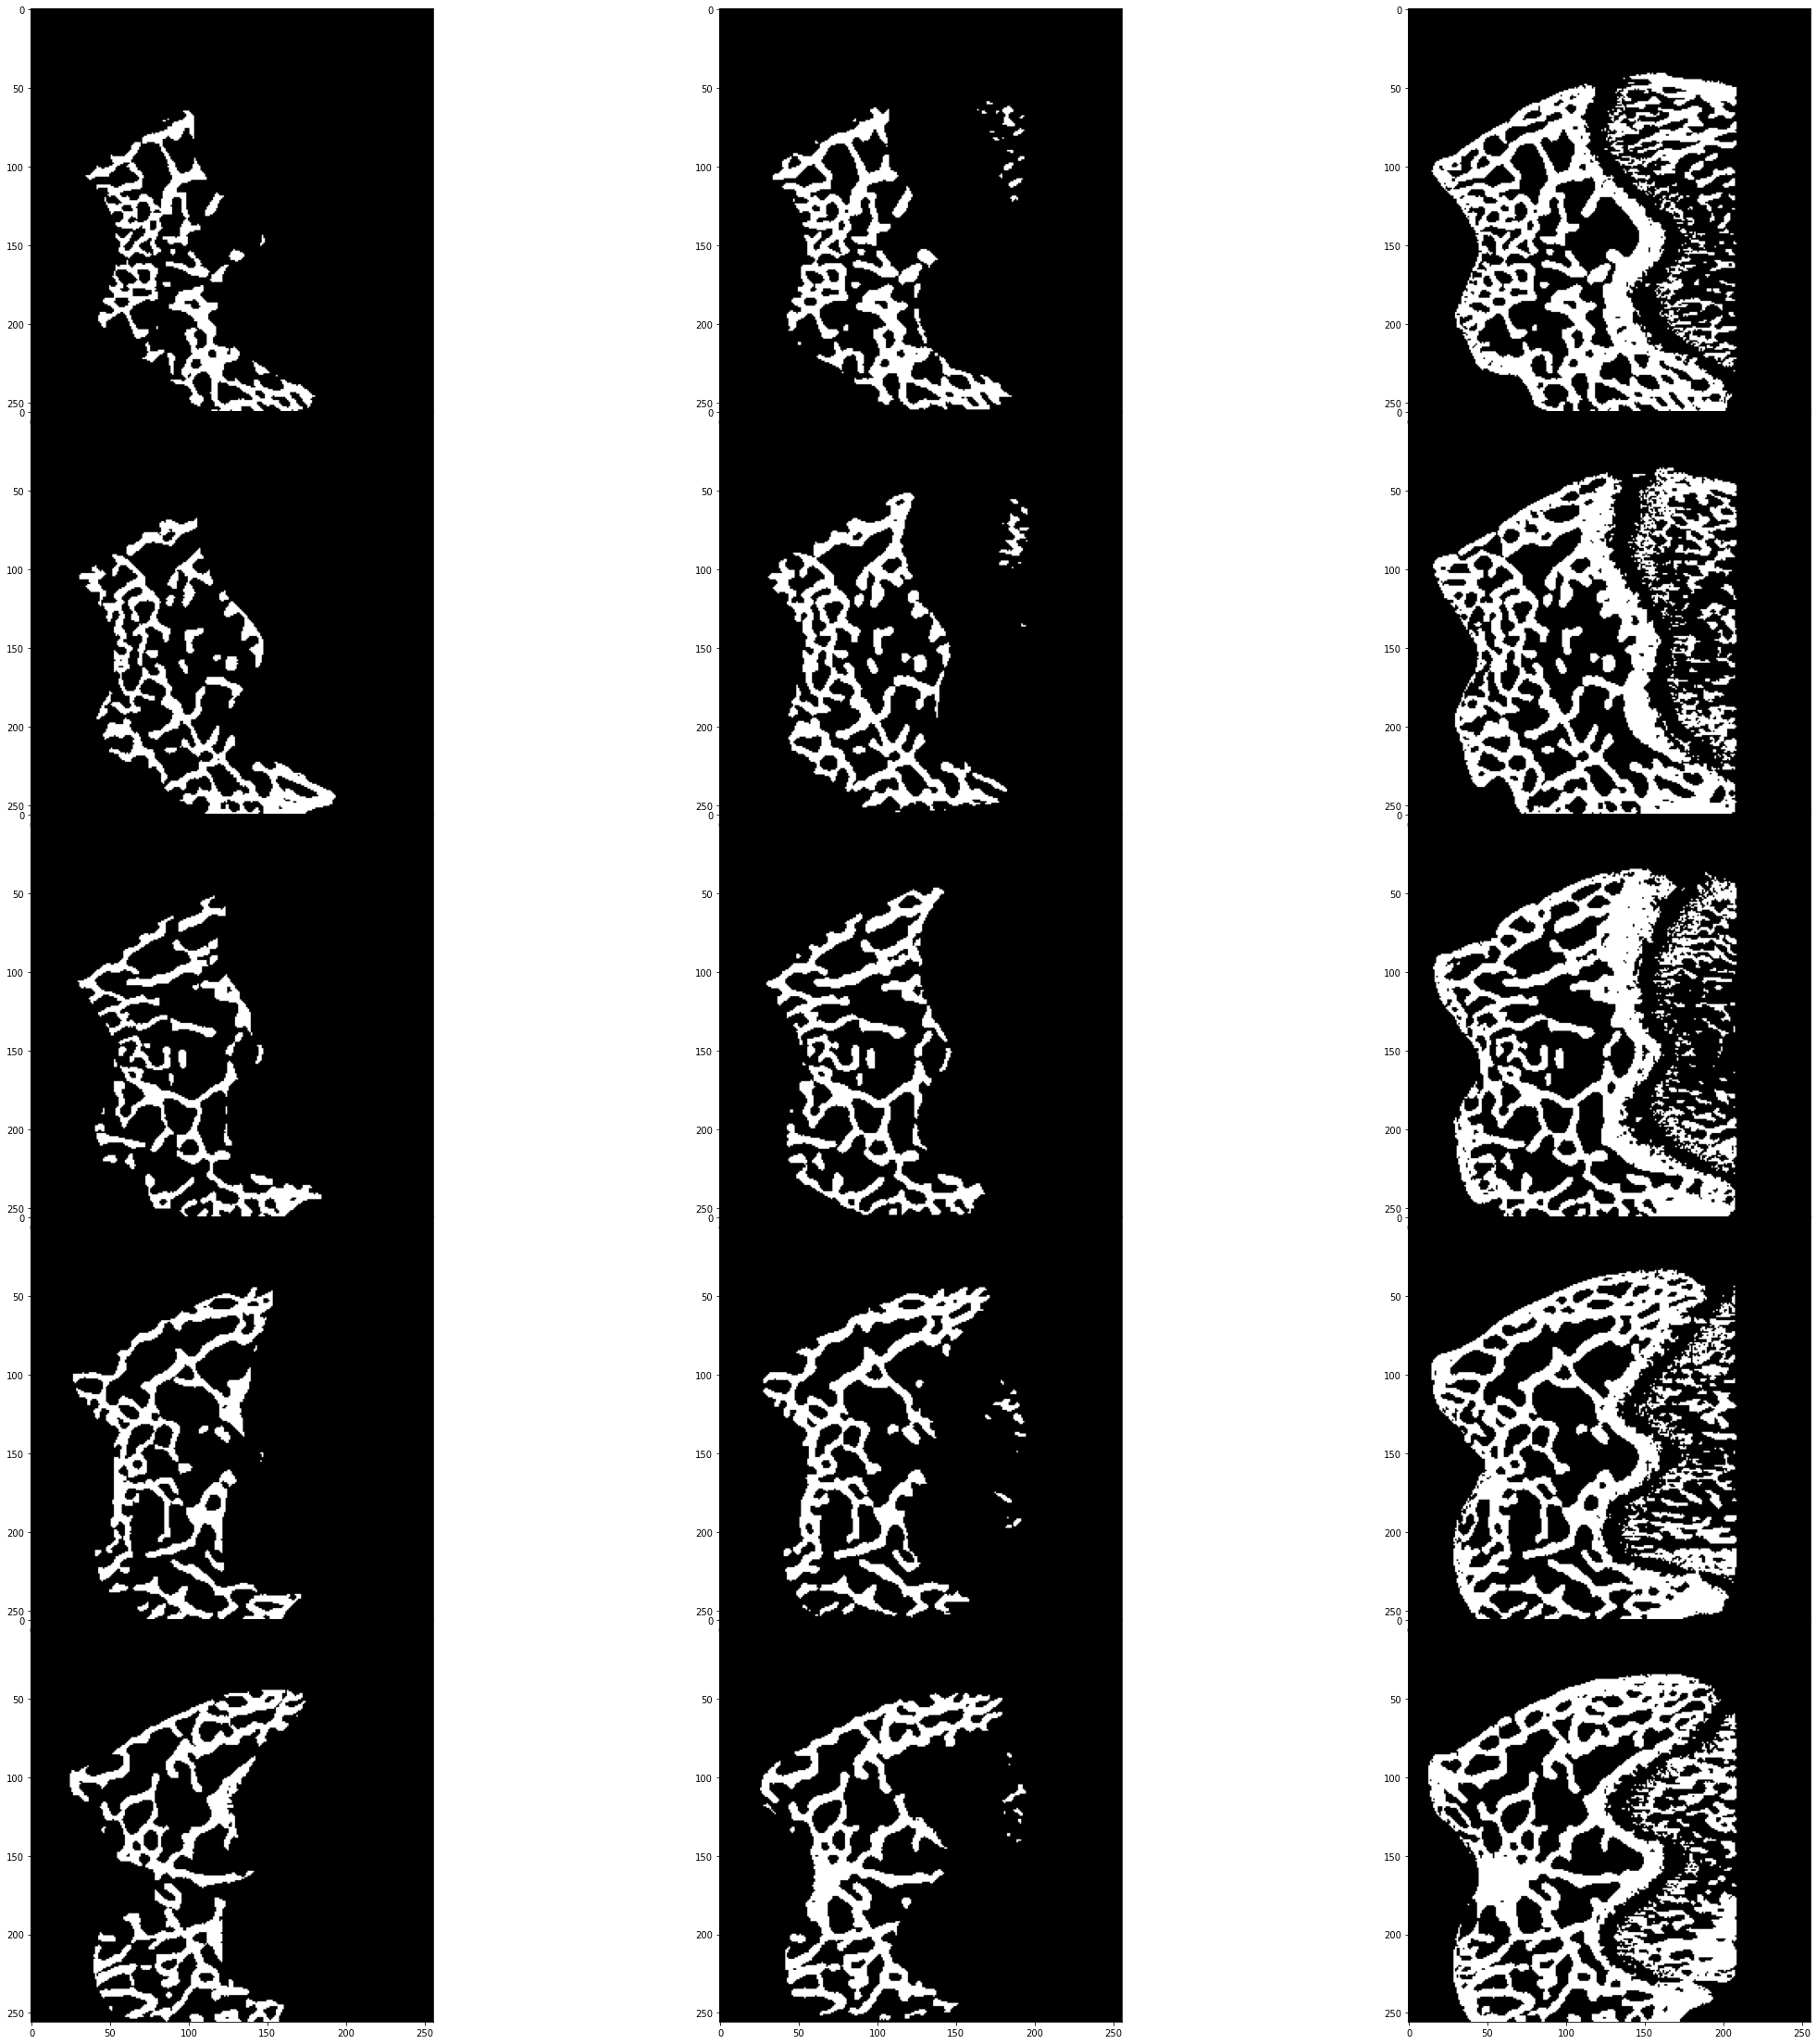

In [101]:
#f, axarr = plt.subplots(u_stack.shape[0],2,figsize=(40,40),squeez=True)
f, axarr = plt.subplots(5,3,figsize=(40,40),gridspec_kw={'wspace':0, 'hspace':0},squeeze=True)
#for i in range(u_stack.shape[0]):
for i in range(5):
    axarr[i,0].imshow(val_u_mask[i*10])
    axarr[i,1].imshow(val_pred[i*10])
    axarr[i,2].imshow(cv2.addWeighted( val_u_stack[i*10], .0001, val_pred[i*10], .9, 0.0,dtype=cv2.CV_8UC3))

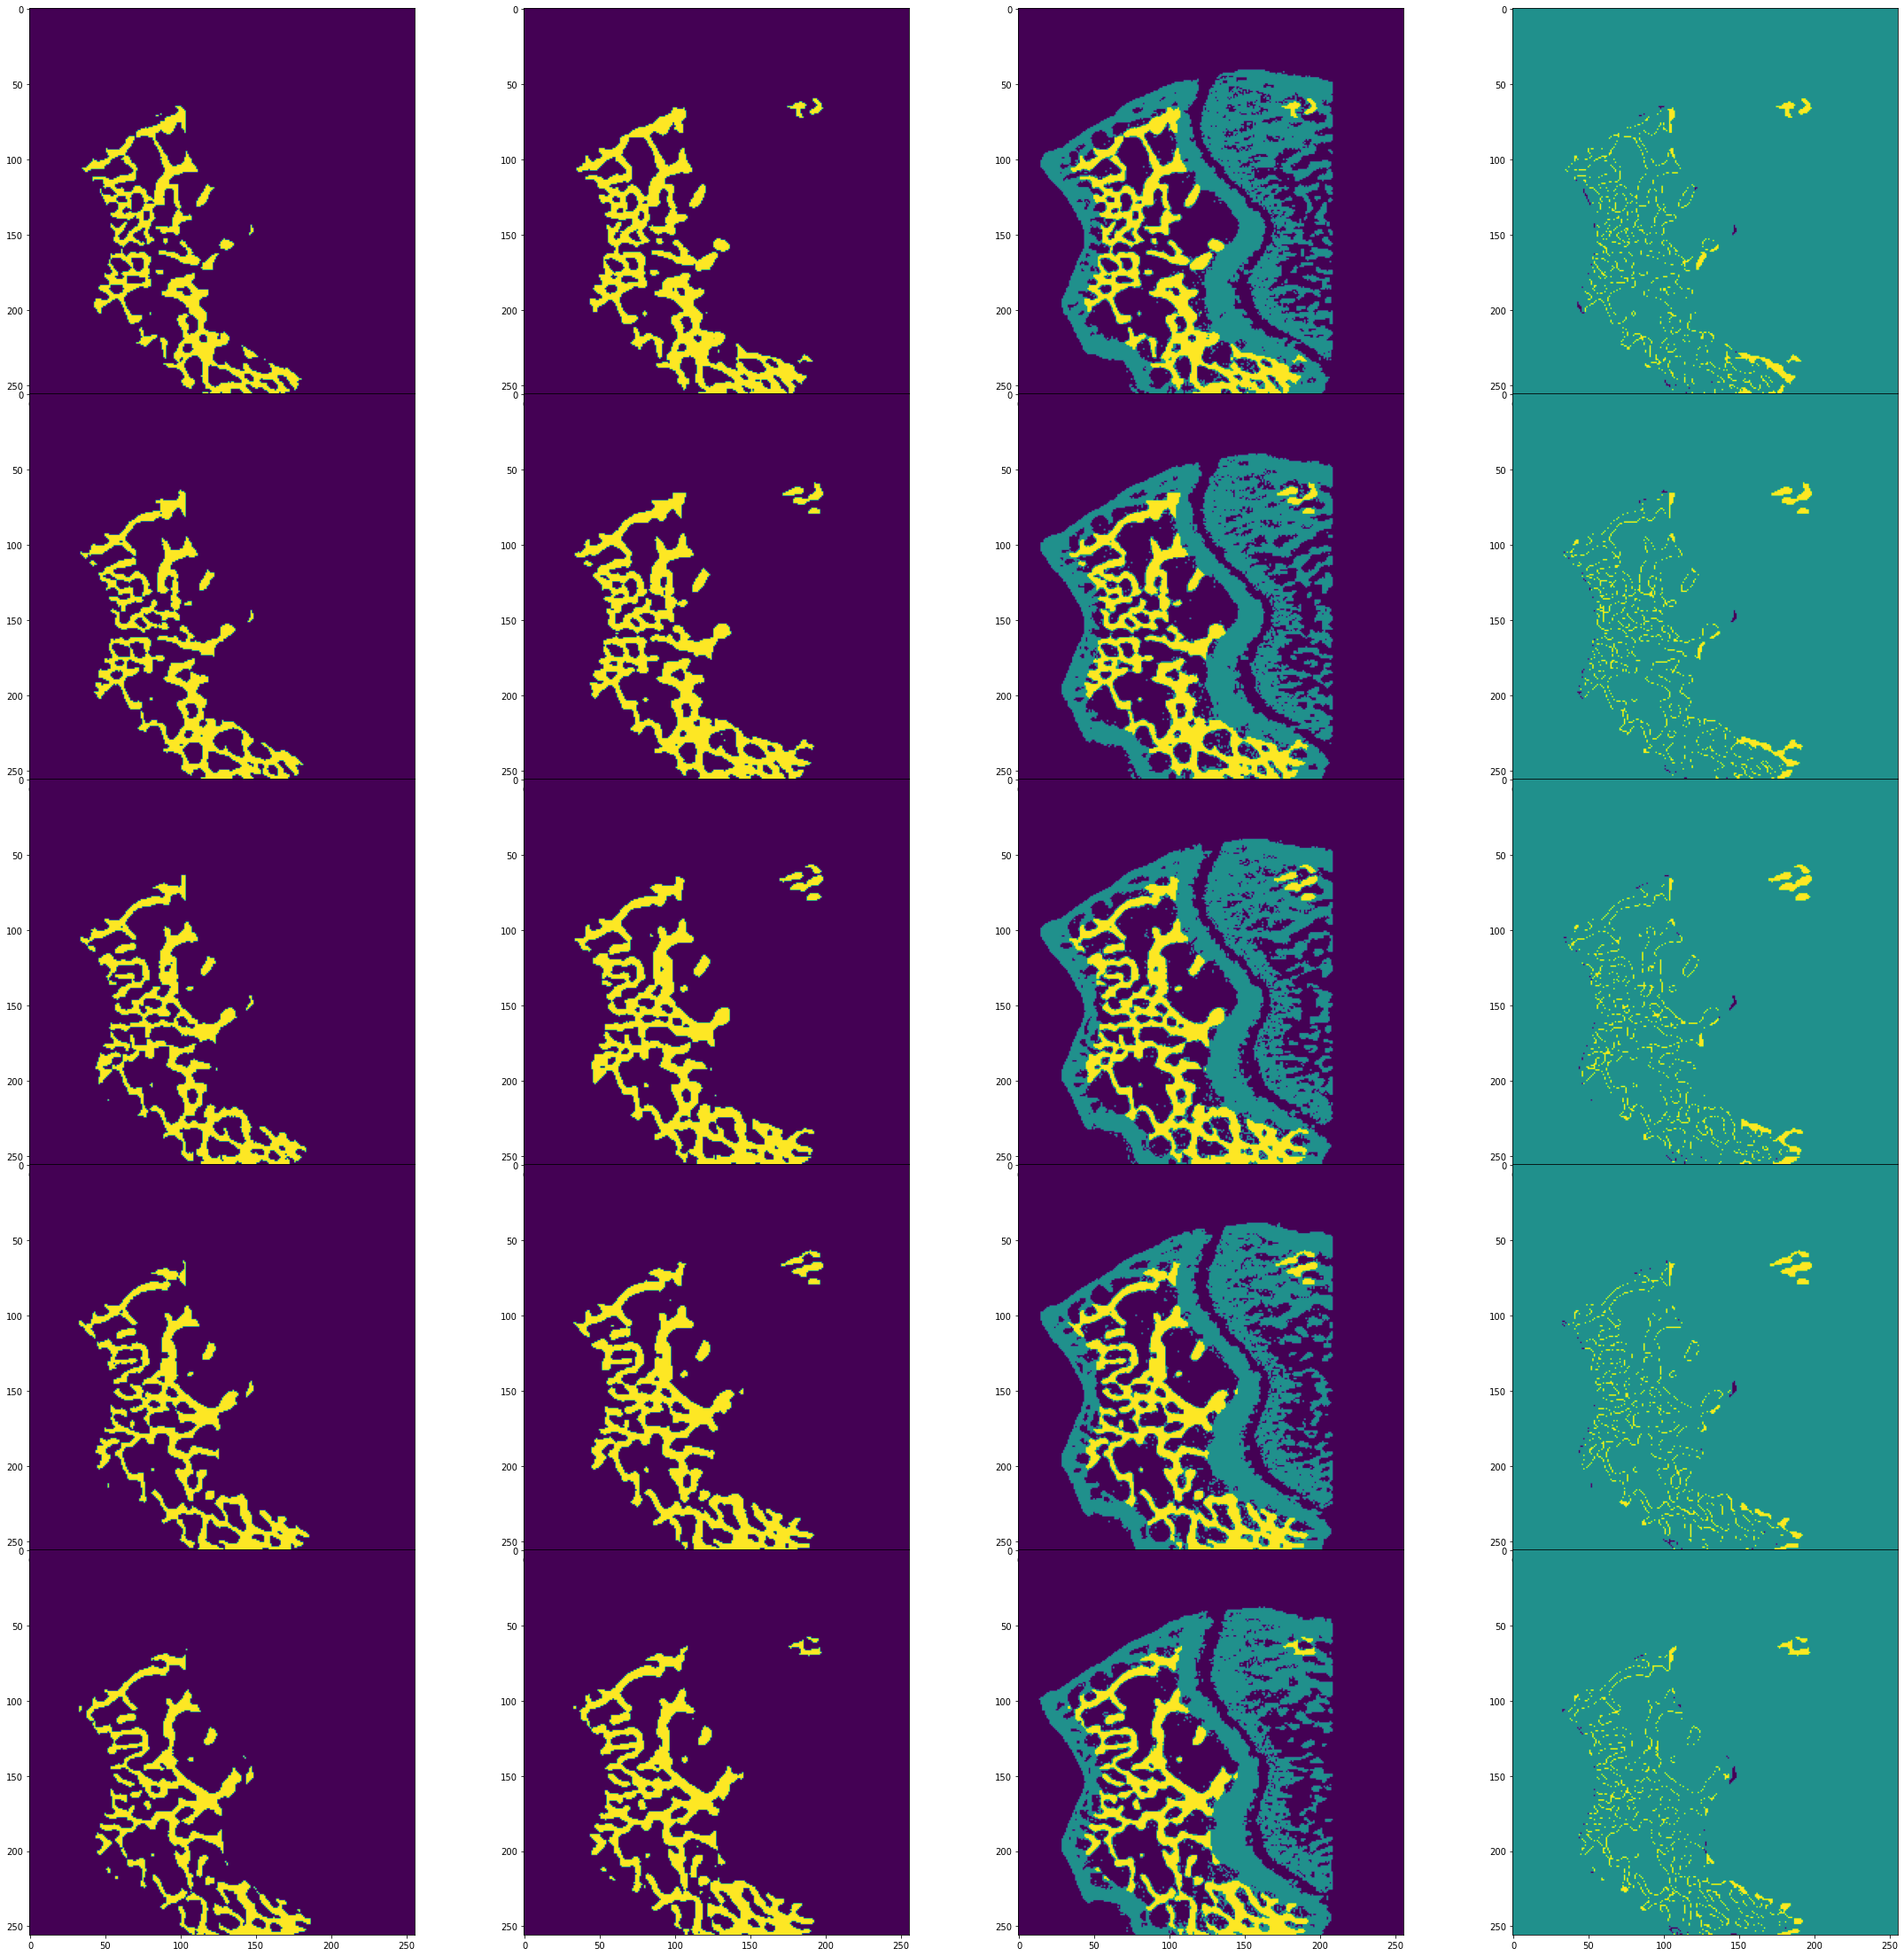

In [26]:
#f, axarr = plt.subplots(u_stack.shape[0],2,figsize=(40,40),squeez=True)
f, axarr = plt.subplots(5,4,figsize=(40,40),gridspec_kw={'wspace':0, 'hspace':0},squeeze=True)
#for i in range(u_stack.shape[0]):
for i in range(5):
    axarr[i,0].imshow(val_u_mask[i])
    axarr[i,1].imshow(val_pred[i*1])
    axarr[i,2].imshow(cv2.addWeighted( val_u_stack[i*1], .00015, val_pred[i*1], .9, 0.0,dtype=cv2.CV_8UC3))
    axarr[i,3].imshow(-1*(val_u_mask[i*1]-val_pred[i*1]))

In [ ]:
f.savefig("allnightrun-train-results",bbox_inches='tight')

In [700]:
from scipy.spatial import distance
for i in range(val_u_mask.shape[0]):
    print(distance.dice(val_u_mask[i].ravel(),val_predict[i].ravel()))

0.7488442368949452
0.7398392327578001
0.7357024260394409
0.7397020232360996
0.7455742405446761
0.7437880053284095
0.736835486865215
0.7279508822950373
0.715245341621329
0.7167206143315369
0.7246632213653076
0.7254559145485773
0.7243506610756862
0.7270961988856414
0.7347428073174713
0.7396913791329593
0.7379953344463018
0.7386078564932171
0.7419058576519201
0.746588215565418
0.7463415492819329
0.7372182182225663
0.7293273449878742
0.7243025901198067
0.7165493226844555
0.7087773376980151
0.7060273685453209
0.7001323163549739
0.7016090158119999
0.7030725286845106
0.7038541193809312
0.7014732273057348
0.6926452258167335
0.6831066841121572
0.6799624894819591
0.678573684293415
0.6790667497498152
0.6837001966392158
0.6857330929006004
0.6907803317381642
0.686257357501126
0.6847803360797823
0.6874067204308955
0.6865617467285613
0.6816002873926496
0.6745374902826748
0.6690182842161582
0.6745289447789755
0.6760404585489912
0.6768826369582196


In [12]:
def dice(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

In [15]:
d = []
for i in range(val_u_mask.shape[0]):
    d.append(dice(val_u_mask[i],val_pred[i]))

In [23]:
print(d)

[0.856524483722608, 0.8524280189084659, 0.8559322033898306, 0.8633356545961003, 0.8596866096866097, 0.8561673815985292, 0.861101666099966, 0.8563930123841549, 0.8515034695451041, 0.846709717097171, 0.8433356868282733, 0.8431771894093686, 0.8497118828842859, 0.841941988521793, 0.8426606971538215, 0.8408315738184181, 0.8527818808468735, 0.8513558201058201, 0.8406184705390723, 0.8320853773990877, 0.8181976339596382, 0.8236761160528723, 0.831300646639928, 0.8451159408580431, 0.8403862762031875, 0.8297204136346228, 0.8244829937125975, 0.8255119776316784, 0.8114933837429111, 0.7889069184245464, 0.7834989911067932, 0.7887366360487879, 0.7552931009650007, 0.7553265561899457, 0.7494670242761846, 0.7399634418793583, 0.7475197408382264, 0.7392886014551334, 0.7335301220984838, 0.7313898305084746, 0.7285742958453202, 0.7163222600052315, 0.7170654746252958, 0.7115934494411229, 0.7027476038338658, 0.7034166304954425, 0.7229421202023941, 0.7268223199355918, 0.7254767969186805, 0.7269455132183195]


In [17]:
np.mean(np.asarray(d))

0.7988599119056606

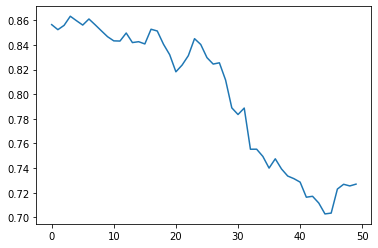

In [25]:
plt.plot(d)

In [7]:
val_stack_slices = np.load(stack_files_npy[0])[150:200]
val_mask_slices = np.load(mask_files_npy[0])[150:200]

val_stack_list = []
val_mask_list = []
val_stack_like = np.zeros((val_stack_slices.shape[0],val_stack_slices.shape[0]))
val_mask_like = np.zeros((val_mask_slices.shape[0],val_mask_slices.shape[0]))

for i in range(val_stack_like.shape[0]):
    val_stack_list.append(squarify(val_stack_slices[i],0,change_dim=1)[:256,:256])
    val_mask_list.append(squarify(val_mask_slices[i],0,change_dim=1)[:256,:256])
    
val_u_stack = np.asarray(val_stack_list)
val_u_mask = np.asarray(val_mask_list)
val_u_stack = np.expand_dims(val_u_stack, axis=-1)
val_u_mask = np.expand_dims(val_u_mask,axis=-1)

In [9]:
from keras.models import load_model
mac_mod = load_model("C:\\Users\\15714\\Downloads\\mac_model_long-3-2.hdf5",custom_objects = {"dice_loss":dice_loss})

In [11]:
val_pred = mac_mod.predict(val_u_stack)

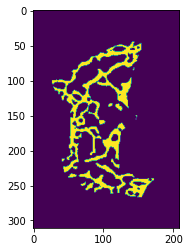

In [640]:
plt.imshow(val_mask_slices[30,:,:])

In [698]:
val_predict = model.predict(val_u_stack)

In [701]:
val_predict.shape

(50, 256, 256, 1)

In [72]:
from keras.models import load_model
mod = load_model("3-1-allnight-train-100-150.h5",custom_objects={'focal_tversky':focal_tversky})

In [73]:
u_stack

NameError: name 'u_stack' is not defined

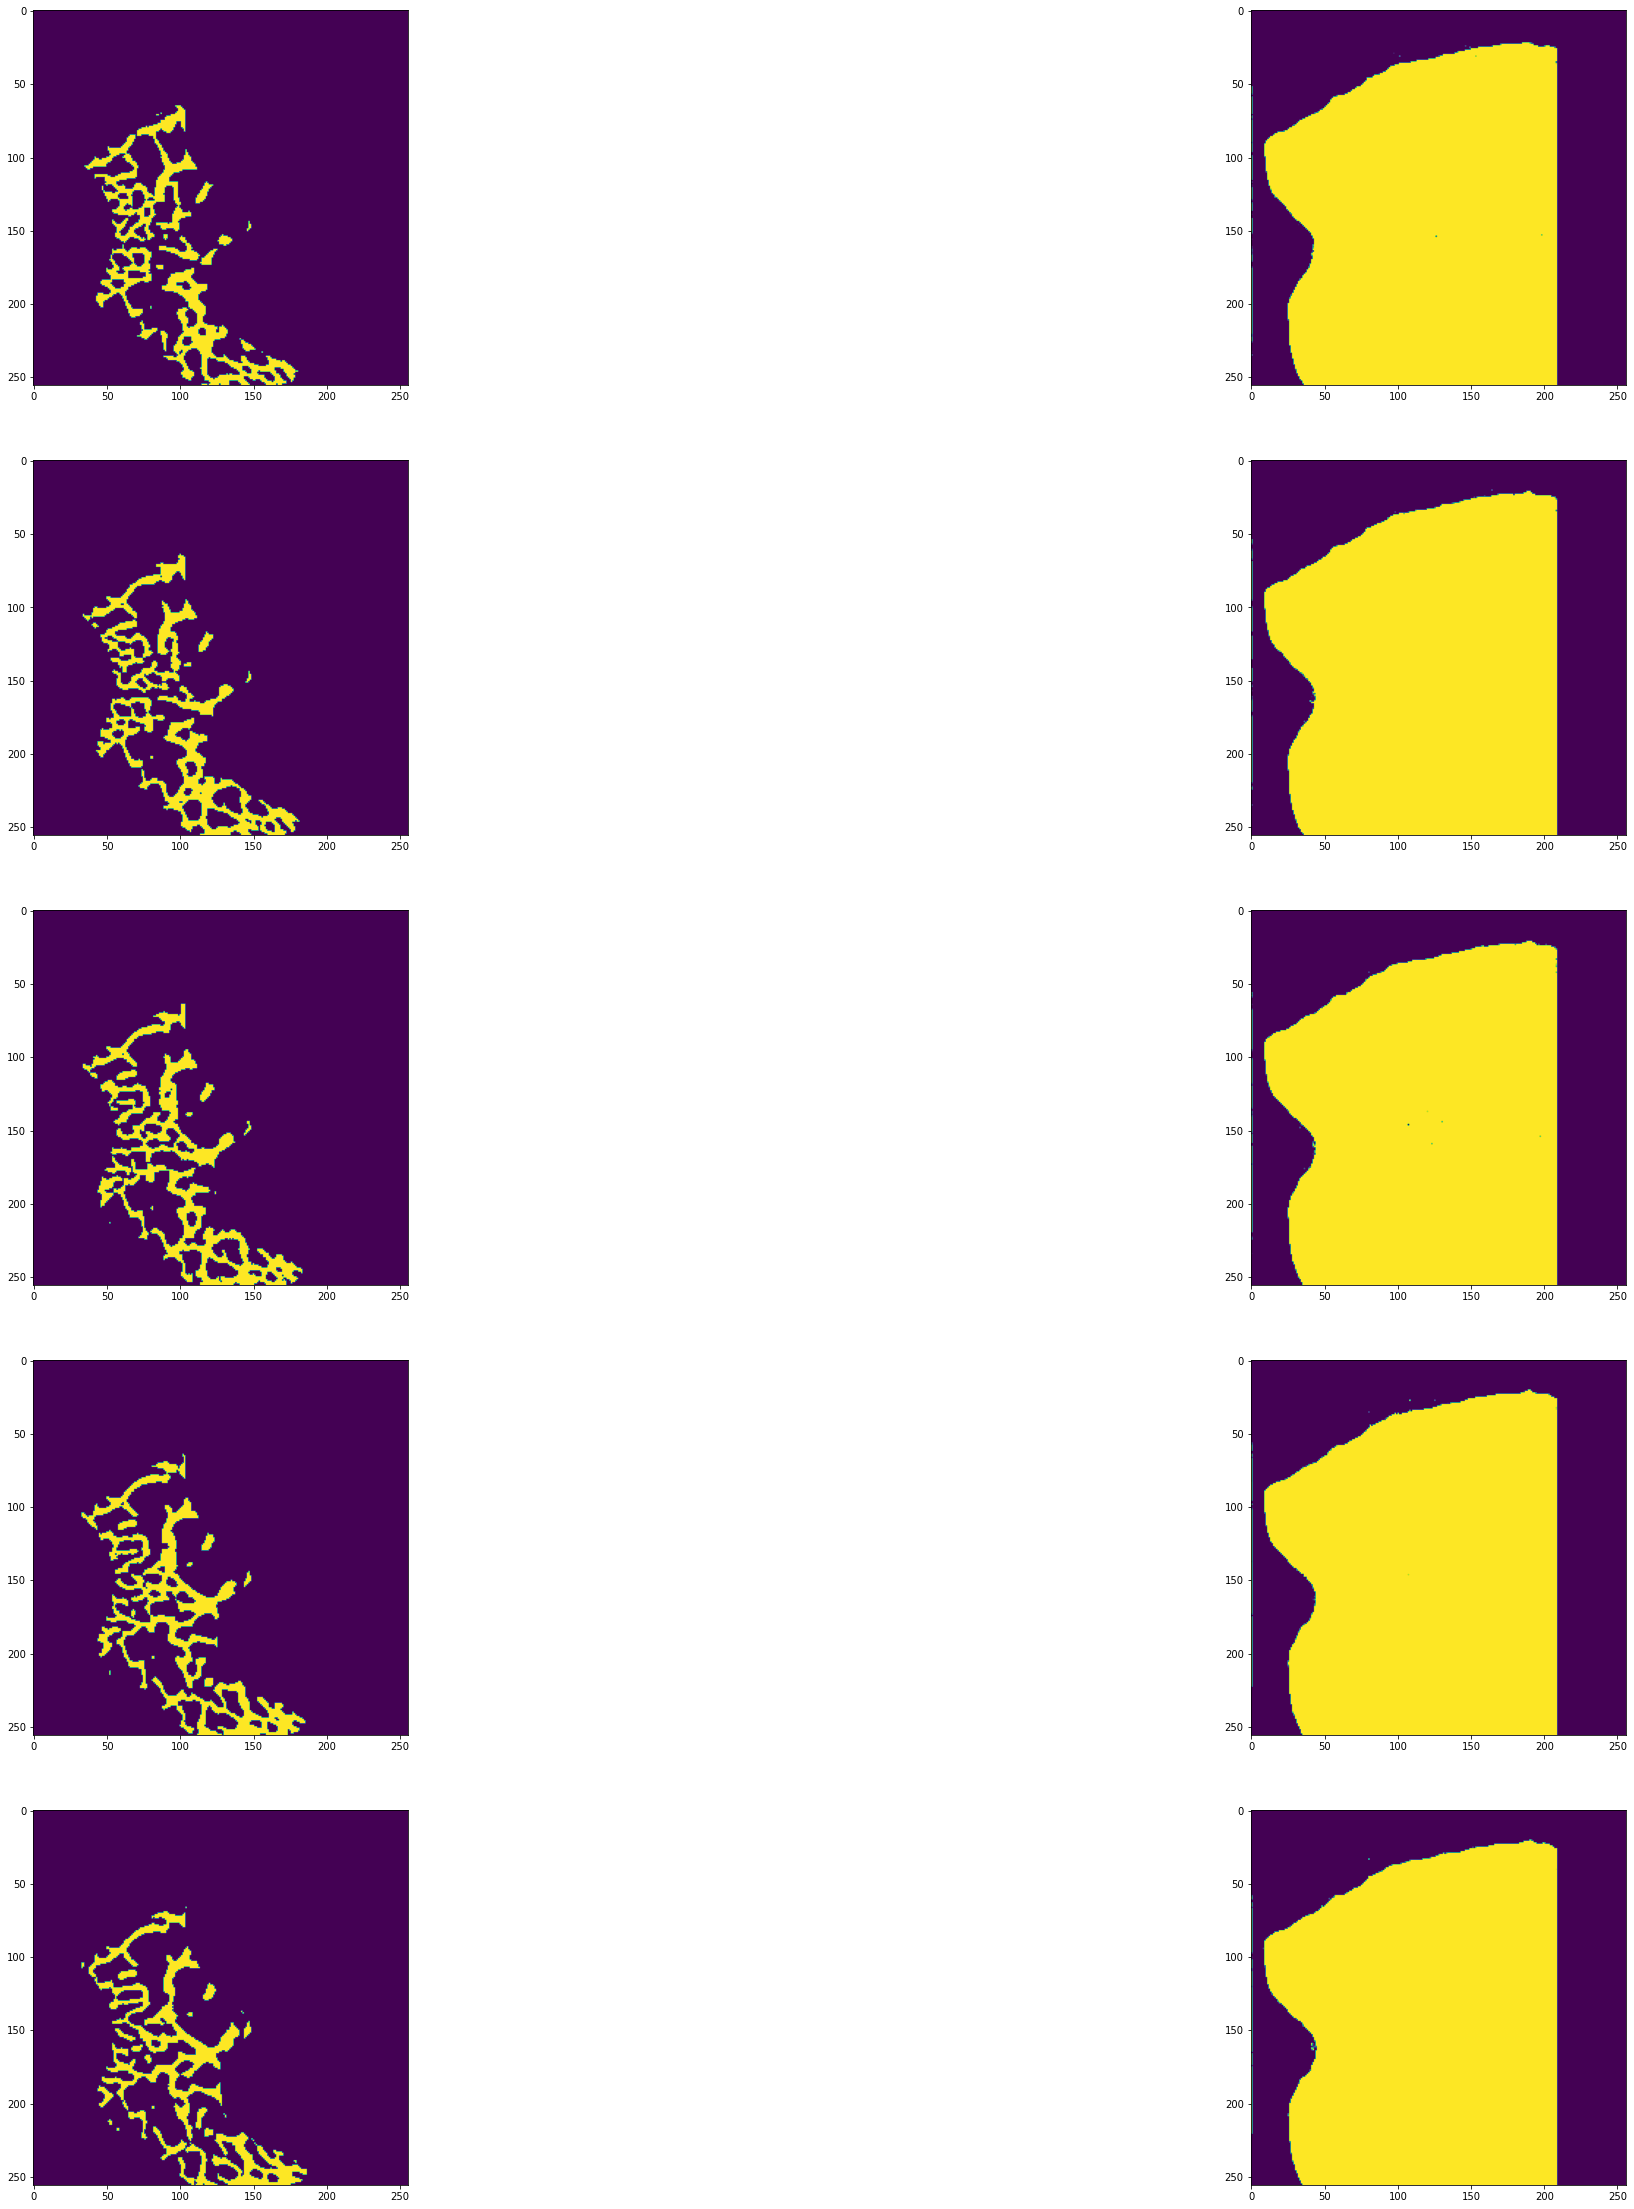

In [702]:
#f, axarr = plt.subplots(u_stack.shape[0],2,figsize=(40,40),squeez=True)
f, axarr = plt.subplots(5,2,figsize=(40,40),squeeze=True)
#for i in range(u_stack.shape[0]):
for i in range(5):
    axarr[i,0].imshow(val_u_mask[i])
    axarr[i,1].imshow(cv2.addWeighted( val_u_stack[40+i], 1, val_predict[40+i], .7, 0.0,dtype=cv2.CV_8UC3))
    #axarr[i,1].imshow(val_predict[i])

In [ ]:
f.savefig("allnightrun-val-results",bbox_inches='tight')

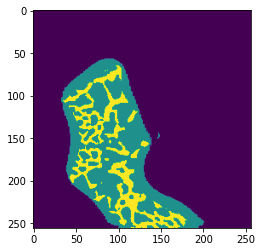

In [618]:
plt.imshow(cv2.addWeighted( val_u_stack[0], 1, val_predict[0], .9, 0.0,dtype=cv2.CV_8UC3))

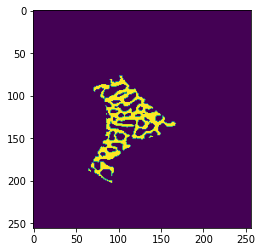

In [624]:
plt.imshow(u_stack[0])

In [369]:
a=predict[0,:,:,0]*1000
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        if(a[i,j]<100):
            a[i,j]=0

In [436]:
predict.shape

(10, 256, 256, 1)

In [374]:
a[np.where(a>100)].shape

(47,)

In [382]:
(np.argwhere(np.any(a > 100, axis=1)))[9]

array([240], dtype=int64)

In [333]:
def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

In [352]:
(predict[0,:,:,0][predict[0,:,:,0]<.2]).shape

(65514,)

In [326]:
np.mean(u_mask[0]*1000)

43.182373046875

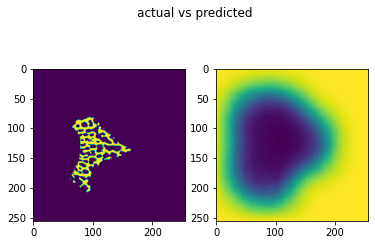

In [206]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('actual vs predicted')

ax1.imshow(u_mask[8])
#ax1.set_ylabel('Damped oscillation')
ax2.imshow(predict[8])

plt.show()

In [ ]:
x1 = np.linspace(0.0, 5.0)
x2 = np.linspace(0.0, 2.0)
y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
y2 = np.cos(2 * np.pi * x2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].plot(x1, y1)
axes[1].plot(x2, y2)
fig.tight_layout()

In [403]:
a.shape

(256, 256)

In [404]:
from skimage.measure import label
b = label(a)

In [405]:
b.shape

(256, 256)

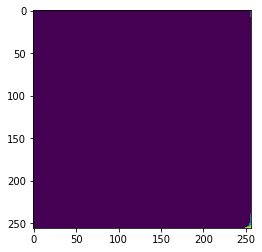

In [407]:
plt.imshow(b)

<h1> CV2 Watershed <h1>

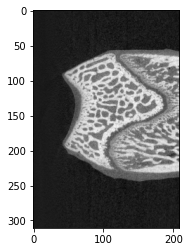

In [45]:
img = (np.load(stack_files_npy[0])[100,:,:])#cv.imread('coins.png')
plt.imshow(img)

In [41]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread('testimg.jpg')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=40)
# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)


# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv.watershed(img,markers)
img[markers == -1] = [255,0,0]

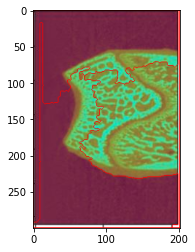

In [42]:
plt.imshow(img)

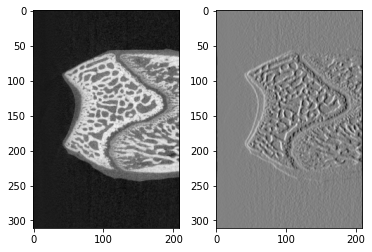

In [50]:
from scipy import ndimage, misc
import matplotlib.pyplot as plt
fig = plt.figure()
plt.gray()  # show the filtered result in grayscale
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
ascent = img#misc.ascent()
sob_result = ndimage.sobel(ascent)
ax1.imshow(ascent)
ax2.imshow(sob_result)
plt.show()

In [64]:
from scipy.ndimage import median_filter
result = median_filter(sob_result,size=5)

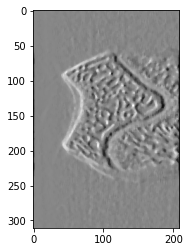

In [65]:
plt.imshow(result)